In [1]:
# Sbi benchmark
import sbibm
from sbibm.metrics import c2st

# torch and so
import torch
import torch.distributions as distrib
from torch import nn
import numpy as np

# Pyro thinks
import pyro
from pyro.distributions import transforms
from pyro.optim import Adam
from pyro.nn import AutoRegressiveNN

# Some others
from sbi.inference.posteriors.variational_posterior import build_flow
from sbi.utils.plot import pairplot

import matplotlib.pyplot as plt

In [2]:
moons = sbibm.get_task("two_moons") 
moons_prior = moons.prior_dist
moons_simulator = moons.get_simulator()
moons_observation = moons.get_observation(num_observation=1) 

# two moons data
moons_thetas = moons_prior.sample((10000,))
moons_xs = moons_simulator(moons_thetas)

# Mixture of normalizing flow

We consider the variational family 
$$ q(\theta; \Phi, \pi) = \sum_{k=1}^K \pi_k q(\theta|\phi_k)$$

The KL divergence is given by
\begin{align*}
D_{KL}(q||p) &= \mathbb{E}_q\left[\log \frac{p(x,\theta)}{q(\theta)}\right]\\
&= \int \log \frac{p(x,\theta)}{q(\theta)} \sum_{k=1}^K \pi_k q(\theta|\phi_k) d\theta\\
&= \sum_{k=1}^K \pi_k \int \log \frac{p(x,\theta)}{q(\theta)} q(\theta|\phi_k)d\theta \\
&= \sum_{k=1}^K \pi_k \mathbb{E}_{q_k}\left[\log \frac{p(x,\theta)}{q(\theta)}\right]
\end{align*}
The gradients with respect to $\phi_k$ are given by
$$ \nabla_{\phi_k} D_{KL}(q||p) = \pi_k \nabla_k \mathbb{E}_{q_k}\left[\log \frac{p(x,\theta)}{q(\theta)}\right]$$
This is important as we can reparameterize each component but not the mixture distribution itself.

Note that for $\pi$ there is an constraint that is $\sum_{k=1}^K \pi_k = 1$. Hence we parameterize it as $\pi = softmax(c)$. Then we can update $c$ unconstrained. The gradient with respect to $\pi_k$ is given by:
$$ \nabla_{\pi_l}D_{KL}(q||p) = \nabla{\pi_l}\sum_{k=1}^K \pi_k \mathbb{E}_{q_k}\left[\log \frac{p(x,\theta)}{q(\theta)}\right] $$


In [5]:
from sbi import inference 
inf = inference.SNLVI(moons_prior)
density_estimator = inf.append_simulations(moons_thetas, moons_xs).train()

Neural network successfully converged after 80 epochs.


In [25]:
class MixtureOfFlows(nn.Module):
    def __init__(self,components):
        super().__init__()
        self.K = len(components)
        self.c = torch.nn.Parameter(torch.ones(self.K), requires_grad=True)
        self.components = components 
        modules = []
        for comp in components:
            modules.append(nn.ModuleList([t for t in comp.transforms[0].parts if isinstance(t, nn.Module)]))
        self.modules = modules
    def forward(self,x):
        return self.log_prob(x)
    def log_prob(self,x):
        mix = torch.softmax(self.c,0)
        probs = 0.
        for i in range(self.K):
            log_comp = self.components[i].log_prob(x)
            prob = mix[i]*log_comp.exp()
            probs += prob
        return torch.log(probs)

    def sample(self,shape):
        with torch.no_grad():
            mix = torch.softmax(self.c,0)
            k = torch.multinomial(mix,1)
            return self.components[k].sample((1,))


In [64]:
q_1 = build_flow(moons_prior,type="iaf", num_flows=3)
q_2 = build_flow(moons_prior,type="iaf", num_flows=3)
q_3 = build_flow(moons_prior,type="iaf", num_flows=3)
q_4 = build_flow(moons_prior,type="iaf", num_flows=3)
model = MixtureOfFlows([q_1,q_2,q_3,q_4])

In [69]:
elbo_particels=1024
comp_optimizers = [torch.optim.Adam(model.modules[k].parameters(), lr=1e-2) for k in range(model.K)]
optimizer_pi = torch.optim.Adam([model.c], lr=1e-3)
obs = moons_observation[torch.randint(moons_observation.size(0), (elbo_particels,))]
for i in range(1000):
    tot_los = 0
    mix = torch.softmax(model.c,0)
    for k in range(model.K):
        comp_optimizers[k].zero_grad()
        q_k = model.components[k]
        samples = q_k.rsample((elbo_particels,))
        #mean_qk = samples.mean(0)
        #mean_ql = model.components[model.K-k-1].sample((elbo_particels,)).mean(0)
        log_q = model.log_prob(samples)
        log_prior = moons_prior.log_prob(samples)
        log_ll = density_estimator.log_prob(obs, context=samples)
        elbo = log_ll + log_prior - log_q
        loss = -mix[k].clone().detach()*elbo.mean() #+ 1/torch.norm(mean_qk - mean_ql)
        loss.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(model.modules[k].parameters(),10.)
        comp_optimizers[k].step()
        tot_los -= mix[k]*elbo.mean()
    optimizer_pi.zero_grad()
    tot_los.backward()
    optimizer_pi.step()

    print(tot_los.detach())


tensor(0.6989)
tensor(1.1841)
tensor(0.7689)
tensor(0.8602)
tensor(0.8964)
tensor(0.7884)
tensor(0.7614)
tensor(0.8158)
tensor(0.8152)
tensor(0.8027)
tensor(0.7573)
tensor(0.7543)
tensor(0.7724)
tensor(0.7600)
tensor(0.7495)
tensor(0.7468)
tensor(0.7515)
tensor(0.7595)
tensor(0.7524)
tensor(0.7335)
tensor(0.7331)
tensor(0.7202)
tensor(0.7290)
tensor(0.7298)
tensor(0.7270)
tensor(0.7375)
tensor(0.7239)
tensor(0.7223)
tensor(0.7334)
tensor(0.7183)
tensor(0.7387)
tensor(0.7296)
tensor(0.7277)
tensor(0.7336)
tensor(0.7368)
tensor(0.7277)
tensor(0.7370)
tensor(0.7254)
tensor(0.7254)
tensor(0.7302)
tensor(0.7308)
tensor(0.7285)
tensor(0.7263)
tensor(0.7353)
tensor(0.7315)
tensor(0.7235)
tensor(0.7232)
tensor(0.7408)
tensor(0.7175)
tensor(0.7143)
tensor(0.7298)
tensor(0.7191)
tensor(0.7154)
tensor(0.7265)
tensor(0.7125)
tensor(0.7097)
tensor(0.7108)
tensor(0.7209)
tensor(0.7112)
tensor(0.7211)
tensor(0.7265)
tensor(0.7077)
tensor(0.7048)
tensor(0.7189)
tensor(0.7242)
tensor(0.7226)
tensor(0.7

In [70]:
samples = torch.vstack([model.sample((1,)) for _ in range(10000)])

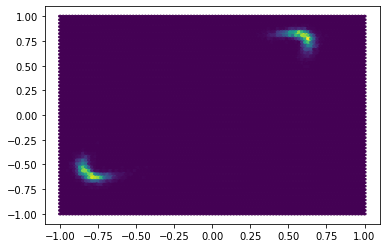

In [71]:
plt.hexbin(samples[:,0], samples[:,1], extent=(-1,1,-1,1))

In [74]:
mix

tensor([0.1257, 0.3668, 0.1901, 0.3174], grad_fn=<SoftmaxBackward>)